In [1]:
import numpy as np
import os
from tqdm.notebook import tqdm
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, RandomSampler
from torch.nn import BCEWithLogitsLoss
import matplotlib.pyplot as plt
from IPython.display import clear_output
from PIL import Image
import albumentations as A

torch.manual_seed(1)


SIZE = (512, 512)

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
TRAIN_IMAGES_PATH = '/content/drive/MyDrive/data_for_project/images_train'
VAL_IMAGES_PATH = '/content/drive/MyDrive/data_for_project/images_val'

TRAIN_MASKS_PATH = '/content/drive/MyDrive/data_for_project/masks_train'
VAL_MASKS_PATH = '/content/drive/MyDrive/data_for_project/masks_val'

In [ ]:
print(f'Размер обучающего датасета: {len(os.listdir(TRAIN_IMAGES_PATH))}')
print(f'Размер валидационного датасета: {len(os.listdir(VAL_IMAGES_PATH))}')

Размер обучающего датасета: 43
Размер валидационного датасета: 7


In [5]:
img_name = "fig1.png"
mask_name = "mask1.png"

img_path = os.path.join(TRAIN_IMAGES_PATH, img_name)
mask_path = os.path.join(TRAIN_MASKS_PATH, mask_name)

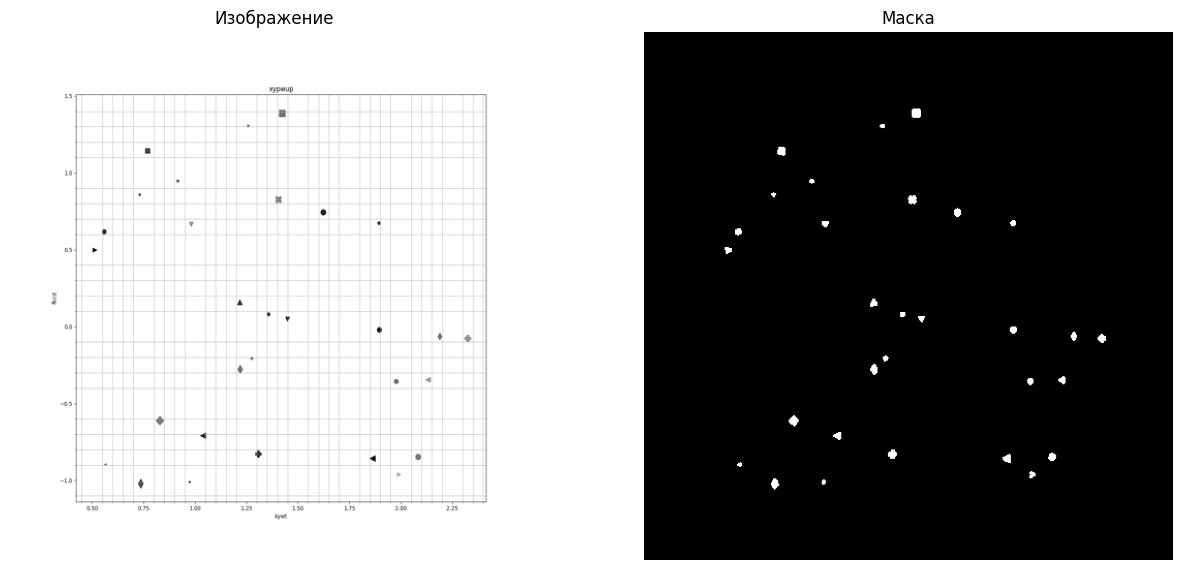

In [6]:
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.title("Изображение")
plt.imshow(Image.open(img_path), 'gray')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Маска")
plt.imshow(Image.open(mask_path), 'gray')
plt.axis("off");

In [7]:
image = np.array(Image.open(img_path))
mask = np.array(Image.open(mask_path))

In [8]:
image.shape, mask.shape

((512, 512), (512, 512))

In [9]:
class FigsDataset(Dataset):
    def __init__(self, data_path, mask_path, aug=None):
        """
        Args:
            data_path: путь до изображений.
            mask_path: путь до масок изображений.
        """
        self.data_path = data_path
        self.mask_path = mask_path

        self.files = os.listdir(self.data_path)
        self.mask_files = os.listdir(self.mask_path)

        assert len(self.files) == len(self.mask_files)


        self.files.sort()
        self.mask_files.sort()

        self.aug = aug

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_name = os.path.join(self.data_path, self.files[idx])
        mask_name = os.path.join(self.mask_path, self.mask_files[idx])

        input = np.array(Image.open(file_name), dtype=np.uint8)
        target = np.array(Image.open(mask_name), dtype=np.uint8)

        if self.aug:
            augmented = self.aug(image=input, mask=target)
            input = augmented['image']
            target = augmented['mask']

        input = torch.tensor(input, dtype=torch.float32).unsqueeze(0)
        target = torch.from_numpy(target)

        target = (target > 0).int().unsqueeze(0)

        return input, target

In [10]:
aug = A.Compose([
    A.RandomResizedCrop(height=SIZE[0], width=SIZE[1], scale=(0.5, 1.0), p=0.7),
    A.Flip(p=0.7),
    A.Rotate(p=0.5, limit=180, border_mode=1),
    A.Sharpen(p=0.4)])


train_dataset = FigsDataset(TRAIN_IMAGES_PATH, TRAIN_MASKS_PATH, aug=aug)
val_dataset = FigsDataset(VAL_IMAGES_PATH, VAL_MASKS_PATH)

Значения в маске и количество значений: (array([0, 1], dtype=int32), array([260573,   1571]))


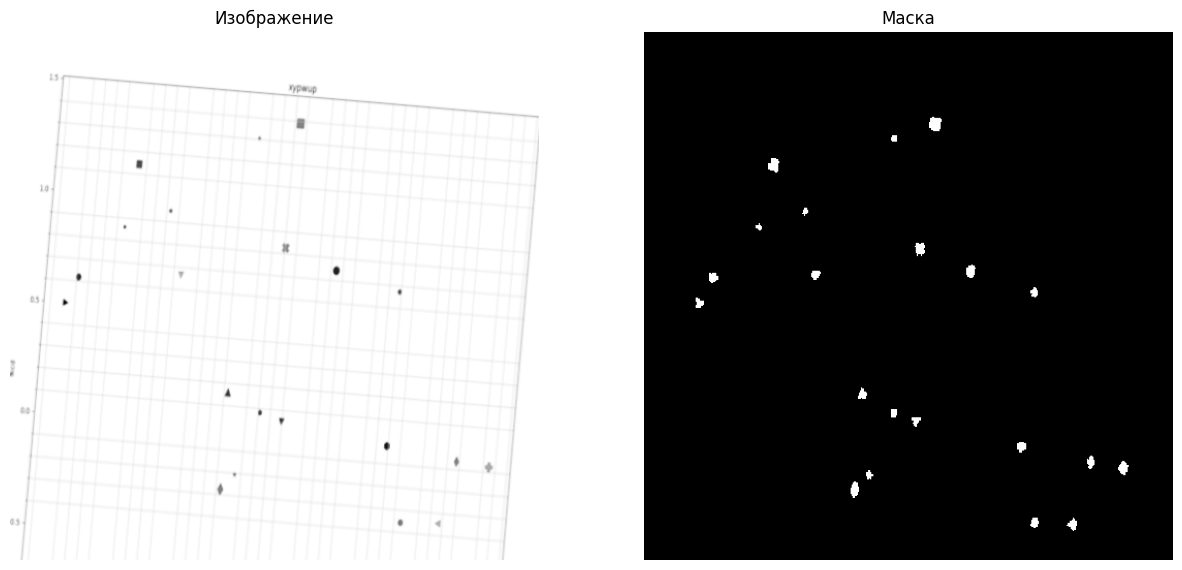

In [11]:
i = 1

plt.figure(figsize=(15, 7))

sample = train_dataset[i]

plt.subplot(1, 2, 1)
plt.title("Изображение")
plt.imshow(sample[0].squeeze(), cmap='Greys_r')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Маска")
plt.imshow(sample[1].squeeze(), cmap='Greys_r')
plt.axis("off");

print("Значения в маске и количество значений:", np.unique(train_dataset[i][1], return_counts=True))

In [12]:
def iou(predicted_mask_batch, target_mask_batch):
    """ Считает среднее IoU для всех элементов батча """
    intersection = (predicted_mask_batch & target_mask_batch).sum(dim=(1, 2, 3))
    union = (predicted_mask_batch | target_mask_batch).sum(dim=(1, 2, 3))
    iou = intersection/union
    return iou.mean()

In [13]:
def conv_bn_relu(in_channels, out_channels, kernel=3, stride=1, padding=1):
    net = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 
                  kernel_size=kernel, stride=stride, padding=padding),
        nn.BatchNorm2d(num_features=out_channels),
        nn.ReLU(inplace=True)
    )
    return net


class Stacked2ConvsBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Stacked2ConvsBlock, self).__init__()
        self.blocks = nn.Sequential(
            conv_bn_relu(in_channels, out_channels), 
            conv_bn_relu(out_channels, out_channels)
        )

    def forward(self, net):
        net = self.blocks(net)
        return net


class UpSamplingBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpSamplingBlock, self).__init__()
        self.upsample = nn.ConvTranspose2d(
            in_channels, in_channels, kernel_size=2, stride=2)
        self.convolve = Stacked2ConvsBlock(2 * in_channels, out_channels)

    def forward(self, left_net, right_net):
        right_net = self.upsample(right_net)
        net = torch.cat((left_net, right_net), dim=(1)) 
        net = self.convolve(net) 
        return net

    
class DownSamplingBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownSamplingBlock, self).__init__()
        self.blocks = nn.Sequential(
            nn.MaxPool2d(2, 2),
            Stacked2ConvsBlock(in_channels, out_channels)
        )
    def forward(self, net):
        return self.blocks(net)


class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()
        self.init_conv = Stacked2ConvsBlock(1, 64) ####

        self.downsample_1 = DownSamplingBlock(64, 128)
        self.downsample_2 = DownSamplingBlock(128, 256)
        self.downsample_3 = DownSamplingBlock(256, 512)
        self.downsample_4 = DownSamplingBlock(512, 1024)    
        
        self.upconv = Stacked2ConvsBlock(1024, 512)

        self.upsample_1 = UpSamplingBlock(512, 256)
        self.upsample_2 = UpSamplingBlock(256, 128)
        self.upsample_3 = UpSamplingBlock(128, 64)
        self.upsample_4 = UpSamplingBlock(64, 64)
        
        self.agg_conv = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        net0 = self.init_conv(x) # 1 --> 64
       
        net1 = self.downsample_1(net0) # 64 --> 128
        net2 = self.downsample_2(net1) # 128 --> 256
        net3 = self.downsample_3(net2) # 256 --> 512
        net = self.downsample_4(net3) # 512 --> 1024
        
        net = self.upconv(net) # 1024 --> 512
        
        net = self.upsample_1(net3, net) # 512 --> 256
        net = self.upsample_2(net2, net) # 256 --> 128
        net = self.upsample_3(net1, net) # 128 --> 64
        net = self.upsample_4(net0, net) # 64 --> 64
        
        net = self.agg_conv(net) # 64 --> 1

        return net

In [14]:
def vis_dataset(val_dataset, segment_model, n_img=4, savefig_dir=None, threshold=0.8):
    plt.figure(figsize=(20, n_img * 3.5))

    for i, (image, mask) in enumerate(val_dataset):
        if i == n_img:
            break

        plt.subplot(n_img, 4, 4 * i + 1)
        plt.imshow(image.permute(1, 2, 0).cpu().int(), cmap='gray')
        plt.axis("off")
        plt.title("Изображение")

        plt.subplot(n_img, 4, 4 * i + 2)
        plt.imshow(mask.squeeze().cpu(), cmap='gray')
        plt.axis("off")
        plt.title("Реальная маска")

        with torch.no_grad():
            pred = segment_model(image.unsqueeze(dim=0).to(device)).squeeze().cpu()

        plt.subplot(n_img, 4, 4 * i + 3)
        plt.imshow(pred > torch.logit(torch.FloatTensor([threshold])), cmap='gray')
        plt.axis("off")
        plt.title("Предсказанная маска")

        plt.subplot(n_img, 4, 4 * i + 4)
        plt.imshow(pred, cmap='gray')
        plt.axis("off")
        plt.title("Логиты")

    if savefig_dir is not None:
        plt.savefig(os.path.join(savefig_dir, f"results.png"))
    plt.show()

In [15]:
def train(
        segment_model,
        optimizer,
        criterion,
        train_dataloader,
        val_dataloader,
        state_dict_path,
        device="cpu",
        n_epochs=20,
        show_interval=20,
        savefig_dir=None,
        load_flag = False
    ):

    history = {}
    history["train_loss"] = []
    history["train_iou"] = []
    history["val_loss"] = []
    history["val_iou"] = []

    start_epoch = 0

    if load_flag == True:
        if os.path.exists(state_dict_path):
            state = torch.load(state_dict_path)
            segment_model.load_state_dict(state["model"])
            optimizer.load_state_dict(state["optimizer"])
            history = state["history"]
            start_epoch = state["epoch"] + 1

    n_train_batches = len(train_dataloader)
    n_val_batches = len(val_dataloader)

    best_val_iou = 0.
    
    end_epoch = start_epoch + n_epochs

    if savefig_dir is not None:
        if not os.path.exists(savefig_dir):
            os.mkdir(savefig_dir)

    for epoch in range(start_epoch, start_epoch + n_epochs):

        print(f"Epoch {epoch}/{end_epoch}")

        segment_model.train()

        train_loss = 0.
        train_iou = 0.

        for i, (image, mask) in enumerate(tqdm(train_dataloader)):
            image = image.to(device)
            mask = mask.to(device)
            pred = segment_model(image)
            loss = criterion(pred, mask.float())
            loss.backward()

            if i == (n_train_batches - 1):
                optimizer.step()
                optimizer.zero_grad()

            loss_ = float(loss.detach().data)
            iou_ = float(iou(pred.detach() > 0., mask > 0).data)
            train_loss += loss_
            train_iou += iou_

        train_loss = train_loss / n_train_batches
        train_iou = train_iou / n_train_batches

        history["train_loss"].append(train_loss)
        history["train_iou"].append(train_iou)

        print('')
        print(f"Total Train:\tloss\t{train_loss:.5f}"
              f"\t\tIoU\t{train_iou:.5f}")

        segment_model.eval()

        val_loss = 0.
        val_iou = 0. 

        with torch.no_grad():
            for image, mask in tqdm(val_dataloader):
                image, mask = image.to(device), mask.to(device)
                pred = segment_model(image)
                loss = criterion(pred, mask.float())
                loss_ = float(loss.data)
                iou_ = float(iou(pred > 0., mask > 0).data)
                
                val_iou += iou_
                val_loss += loss_

        val_loss = val_loss / n_val_batches
        val_iou = val_iou / n_val_batches

        history["val_loss"].append(val_loss)
        history["val_iou"].append(val_iou)

        if history["val_iou"][-1] > best_val_iou:
            torch.save({
                "model": segment_model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "history": history,
                "epoch": epoch,
            }, state_dict_path)
            best_val_iou = history["val_iou"][-1]

        print('')
        print(f"Toatal Valid:\tloss\t{val_loss:.5f}"
              f"\t\tIoU\t{val_iou:.5f}"
              f"\t\tbest IoU\t{best_val_iou:.5f}")
        print('-' * 100)

        clear_output(wait=True)

        if epoch % show_interval == show_interval - 1:
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 2, 1)
            plt.plot(history["train_loss"], label='train')
            plt.plot(history["val_loss"], label='test')
            plt.title("Loss")
            plt.legend()
            plt.subplot(1, 2, 2)
            plt.plot(history["train_iou"], label='train')
            plt.plot(history["val_iou"], label='test')
            plt.title("IoU")
            plt.legend();
            plt.show()
          
            vis_dataset(val_dataset, segment_model, n_img=4, savefig_dir=None)
    return segment_model, history

In [16]:
masks = FigsDataset(TRAIN_IMAGES_PATH, TRAIN_MASKS_PATH, aug=None)
mask_list = iter(masks)

In [17]:
bounds = np.array([float(mask[1].sum()) for mask in masks])

In [18]:
weights = (bounds/(SIZE[0]*SIZE[1])).mean()

In [19]:
print(f'Процентное содержание точек: {100*weights}')

Процентное содержание точек: 0.7296451302461846


In [20]:
pos_weights = torch.FloatTensor([(1-weights)/weights])

In [21]:
train_dataset_exp = FigsDataset(TRAIN_IMAGES_PATH, TRAIN_MASKS_PATH, aug=aug)
val_dataset = FigsDataset(VAL_IMAGES_PATH, VAL_MASKS_PATH)

batch_size = 6

train_sampler_exp = torch.utils.data.RandomSampler(train_dataset_exp)
train_dataloader_exp = DataLoader(train_dataset_exp, batch_size=batch_size, sampler=train_sampler_exp)
val_dataloader_exp = DataLoader(val_dataset, batch_size=batch_size)

In [ ]:

unet = Unet().to(device)
opt = torch.optim.Adam(unet.parameters(), lr=0.001)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weights.to(device)) 

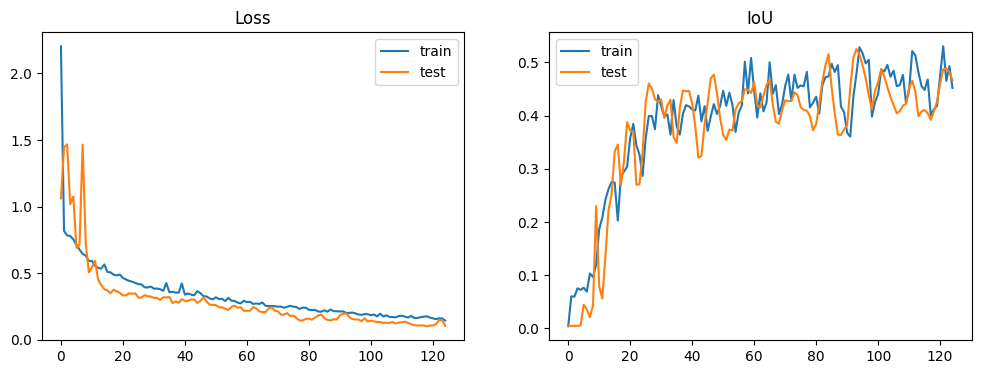

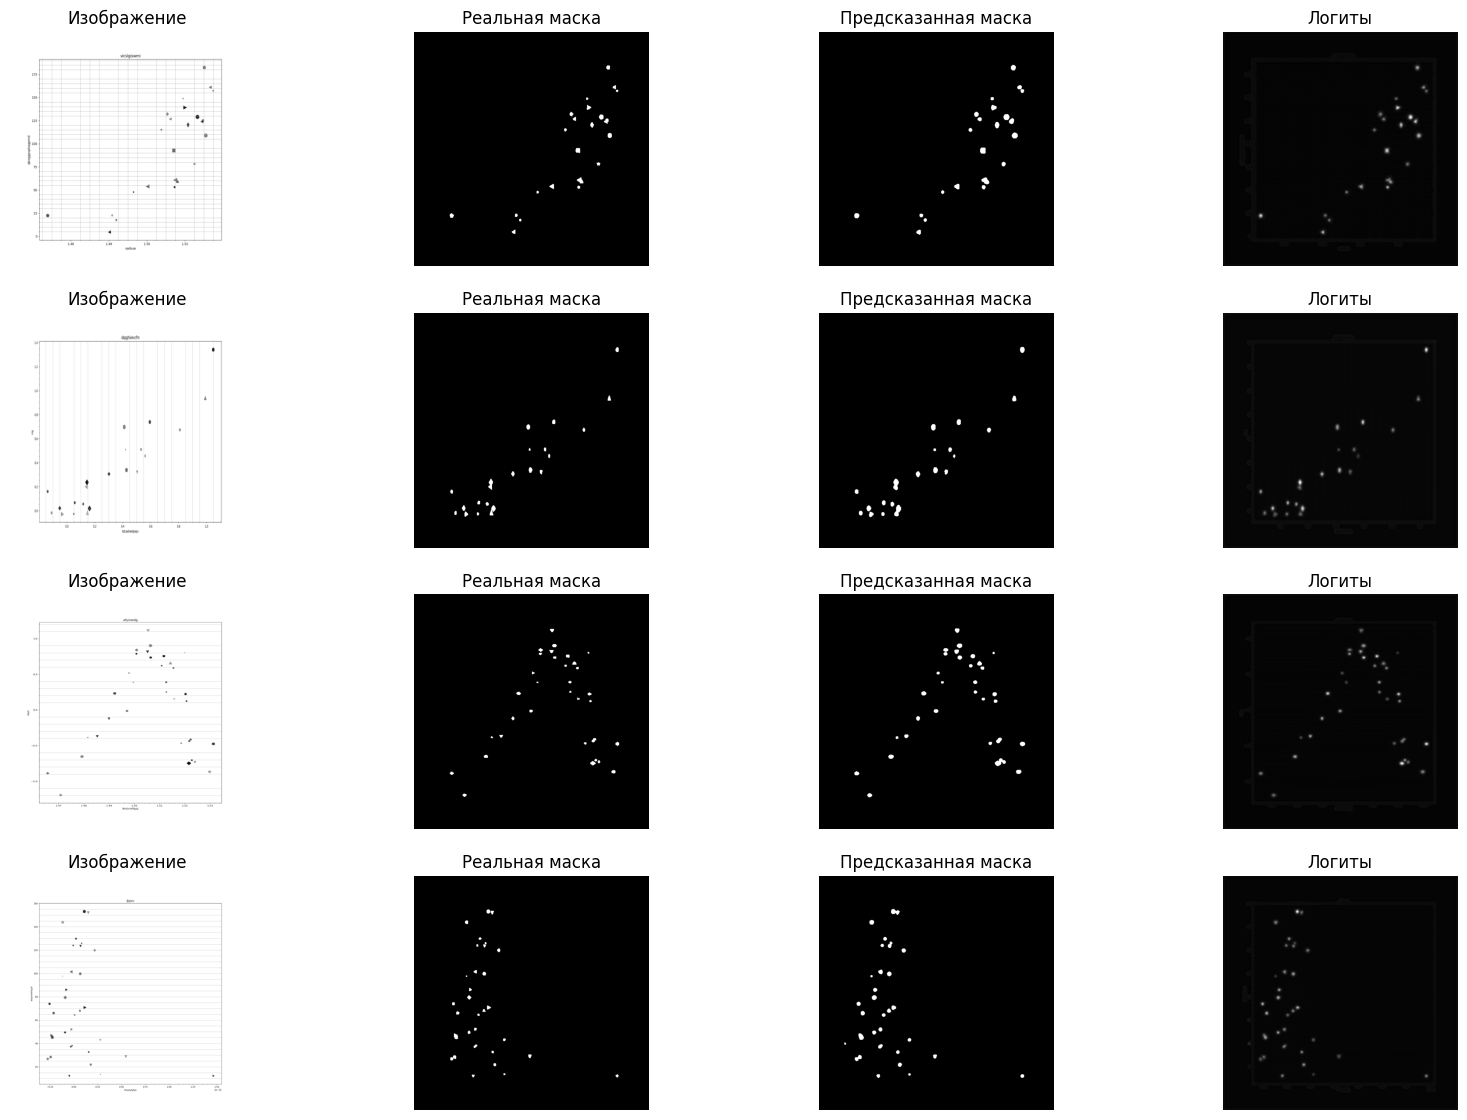

In [ ]:
unet, history = train(
        segment_model=unet,
        optimizer=opt,
        criterion=criterion,
        train_dataloader=train_dataloader_exp,
        val_dataloader=val_dataloader_exp,
        state_dict_path = "/content/drive/MyDrive/data_for_project/additional/exp.pt",
        device=device,
        n_epochs=60,
        show_interval=1,
        savefig_dir=None,
        load_flag=True
    )

In [30]:
segment_model = Unet().to(device)
state = torch.load("/content/drive/MyDrive/data_for_project/additional/exp.pt", map_location=device)
segment_model.load_state_dict(state["model"])
segment_model.eval();

In [32]:
torch.save({
    "model": segment_model.state_dict()
}, "/content/drive/MyDrive/data_for_project/additional/model.pt")

In [23]:
def calculate_iou_with_threshold(segment_model, val_dataset, threshold=0.5):
    val_iou = []
    for img in val_dataset:
        pred = segment_model(img[0].unsqueeze(0).to(device))
        mask = img[1].squeeze().to(device)
        inv_sigmoid = torch.logit(threshold)
        iou_ = float(iou(pred.detach() > inv_sigmoid, mask > 0).data)
        val_iou.append(iou_)

    return np.array(val_iou).mean()    


  0%|          | 0/50 [00:00<?, ?it/s]

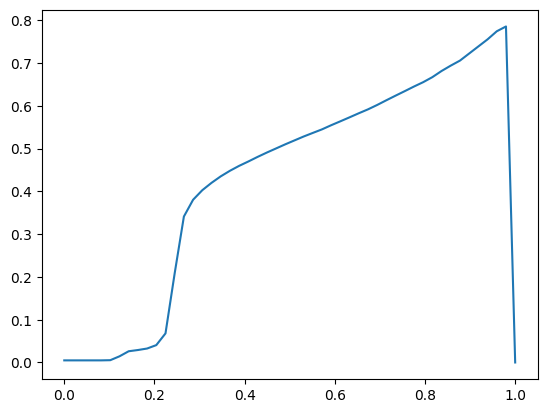

In [24]:
thresholds = torch.linspace(0, 1, 50)
val_ious = []
for i in tqdm(thresholds):
    val_ious.append(calculate_iou_with_threshold(segment_model, val_dataset, i))


plt.plot(thresholds, val_ious)

Text(0, 0.5, 'IoU on validation')

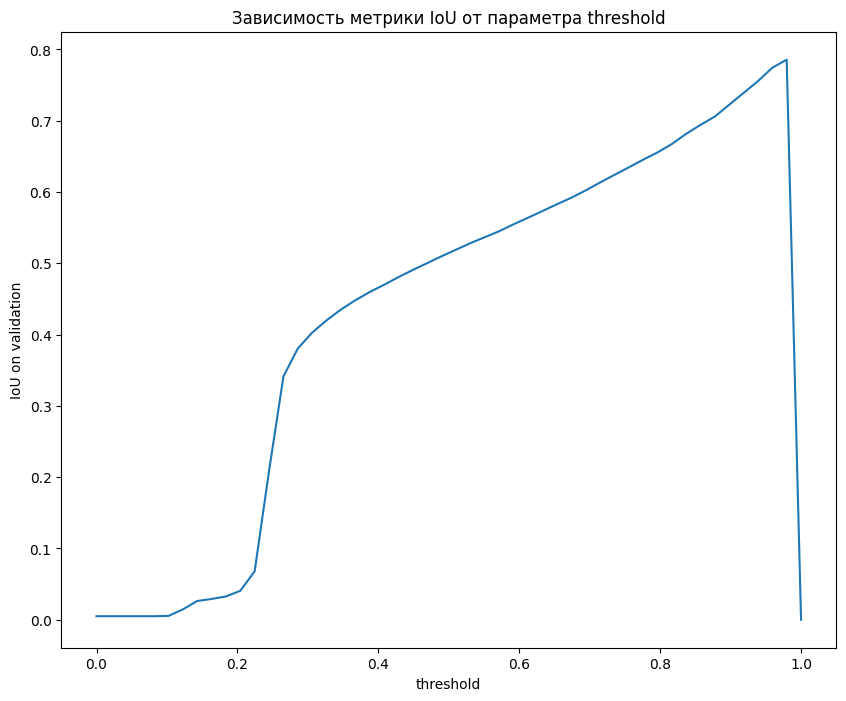

In [25]:
plt.figure(figsize=(10,8))
plt.plot(thresholds, val_ious)

plt.title("Зависимость метрики IoU от параметра threshold")
plt.xlabel("threshold")
plt.ylabel("IoU on validation")

In [26]:
print(val_ious)

[0.004920414515904018, 0.004920414515904018, 0.004920414515904018, 0.004920414515904018, 0.004921808772321258, 0.005345756254558053, 0.014408272158886706, 0.026245230143623694, 0.02910590491124562, 0.032612164105687826, 0.040573635670755594, 0.06797006140862193, 0.2086763850280217, 0.34124524678502766, 0.38044517380850656, 0.4027705022266933, 0.4199436094079699, 0.43509651507650104, 0.4481275039059775, 0.45965081453323364, 0.4698420890739986, 0.4805365673133305, 0.49064730746405466, 0.5002366261822837, 0.5098589318139213, 0.5190122425556183, 0.5281637481280735, 0.5365912531103406, 0.5449223390647343, 0.5546288234846932, 0.5637912239347186, 0.5731076938765389, 0.5825918998037066, 0.5917197465896606, 0.6019900611468724, 0.6130299483026777, 0.6237809828349522, 0.6343456336430141, 0.6450960891587394, 0.6552863121032715, 0.6670563646725246, 0.6814485277448382, 0.6940393788473946, 0.7057557020868573, 0.7223212463515145, 0.738887335572924, 0.7554363778659275, 0.7742985231535775, 0.78552473442

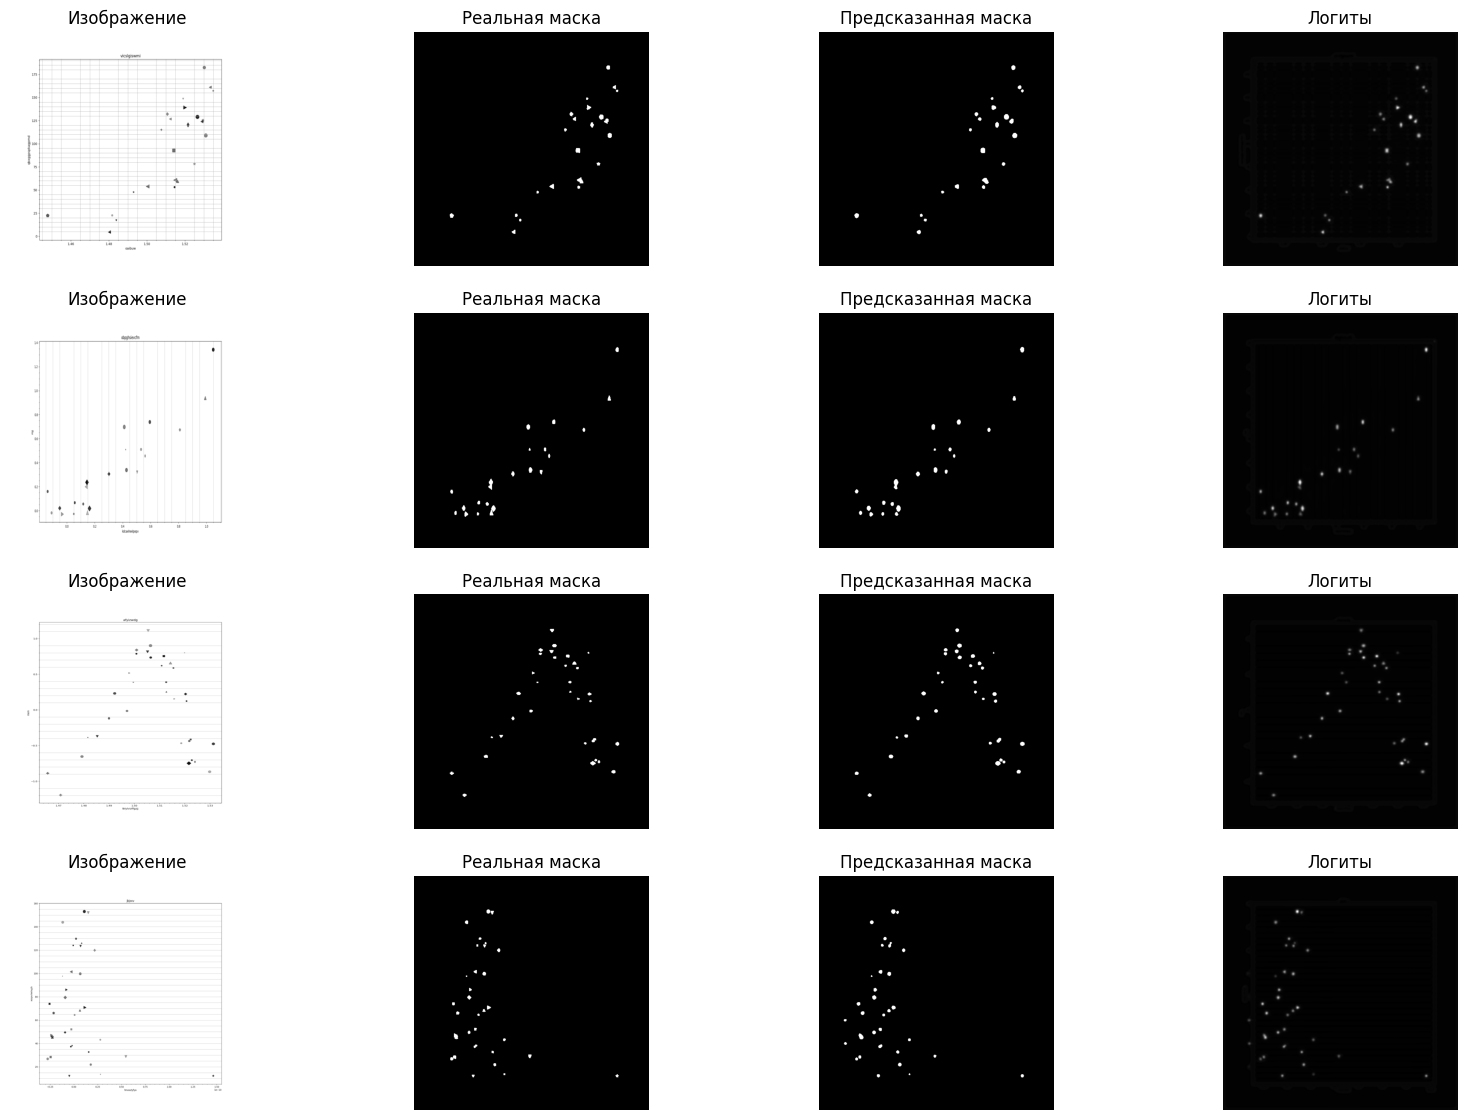

In [29]:
vis_dataset(val_dataset, segment_model, threshold=0.95)